# Importing Libraries

In [12]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

In [13]:
train= pd.read_csv("train.csv")
test= pd.read_csv("predictions.csv")

# EDA: Exploratory Data Analysis

Half way through the hackathon we found out that there is a a linear relation between the target and a selection of features. <br>
Exploiting theses findings gave us a score boost from 900 down to 500.

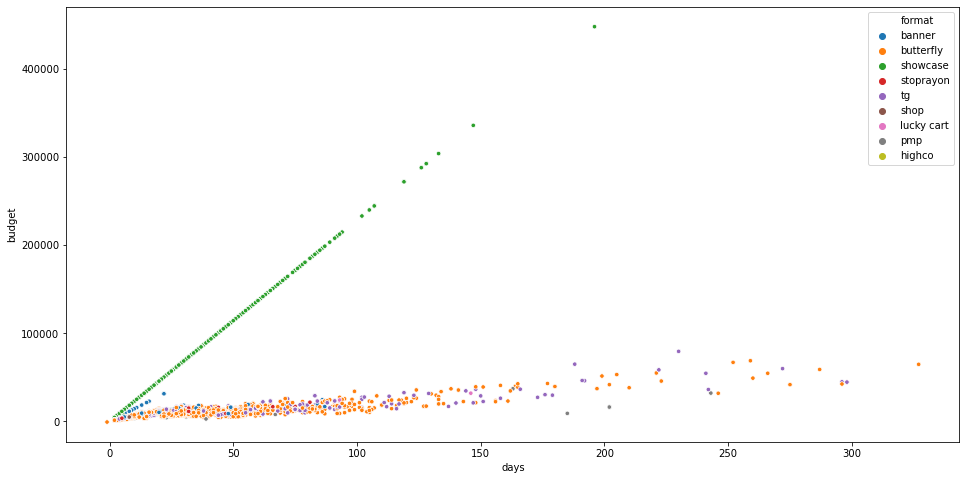

In [14]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=train.days, y= train.budget, cmap="vlag", s=20, hue= train.format)

The figure below presents two lines and the blye one is the most important. <br>
The line is obtain when selecting the format=="showcase" and a width >= 1400. These data points have the highest budget value in all the data and predecting them well will give a very good score. <br>
A linear regression model was applied for these point and produced a rmse of 2.96 e-11

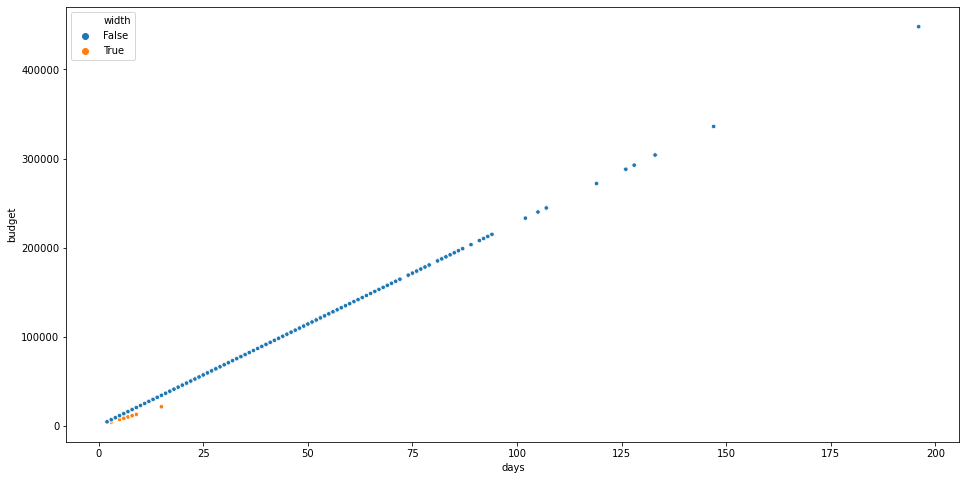

In [15]:
plt.figure(figsize=(16, 8))
train_copy= train.loc[train.format== "showcase"]
sns.scatterplot(x=train_copy.days, y= train_copy.budget, cmap="vlag", s=20, hue=train_copy.width>=1400)

We exploited anotther linerar relation for format=="banner" and width==1200. <br>
The data contains many more similar relations that can help get an even better score howerver, we decided to stop at this level.

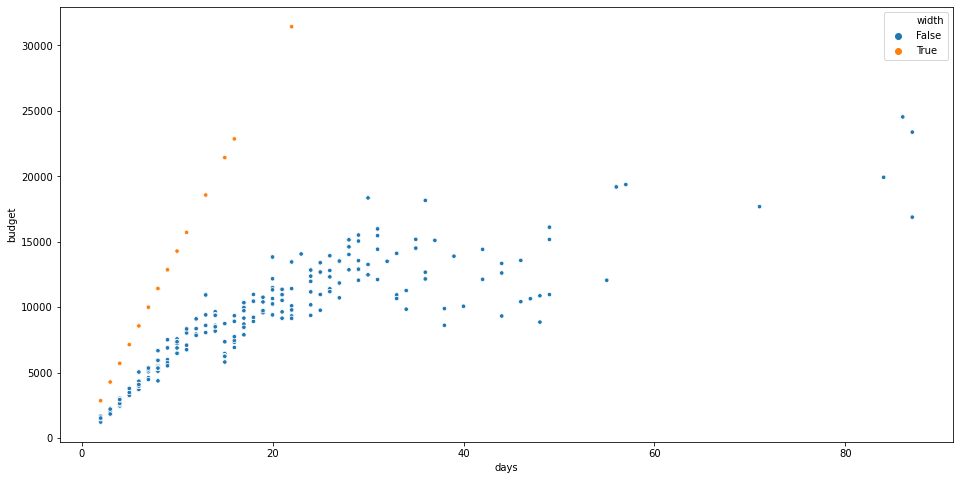

In [16]:
plt.figure(figsize=(16, 8))
train_ss= train.loc[train.format== "banner"]
sns.scatterplot(x=train_ss.days, y= train_ss.budget, cmap="vlag", s=20, hue= train_ss.width==1200)

# Seperating the linearly dependent points

In [17]:
train_s1= train.loc[(train.format== "showcase") & (train.width <1400)]
train_s2= train.loc[(train.format== "showcase") & (train.width >=1400)]
train_s3= train.loc[(train.format== "banner") & (train.width==1200)]

train_ns= train.loc[(train.format!="showcase") & ((train.format!= "banner") | (train.width!=1200))]
train_ns= train_ns.reset_index(drop=True)

test_s1= test.loc[(test.format== "showcase") & (test.width <1400)]
test_s2= test.loc[(test.format== "showcase") & (test.width >=1400)]
test_s3= test.loc[(test.format== "banner") & (test.width==1200)]
test_ns= test.loc[(test.format!="showcase") & ((test.format!= "banner") | (test.width!=1200))]

In the output of the cell below, you can clearly see how well the linear regression model performed on these parts of the dataset. <br>
The second value is not very good however, it doesn't have much effect on the global results as this data part contains very few points (8 instances)

In [18]:
lr1= LinearRegression()
lr1.fit(train_s1.days.values.reshape(-1, 1), train_s1.budget.values.reshape(-1, 1))
w_1, b_1= lr1.coef_, lr1.intercept_

lr2= LinearRegression()
lr2.fit(train_s2.days.values.reshape(-1, 1), train_s2.budget.values.reshape(-1, 1))
w_2, b_2= lr2.coef_, lr2.intercept_

lr3= LinearRegression()
lr3.fit(train_s3.days.values.reshape(-1, 1), train_s3.budget.values.reshape(-1, 1))
w_2, b_2= lr3.coef_, lr3.intercept_

lr_preds1= lr1.predict(train_s1.days.values.reshape(-1,1))
lr_preds2= lr2.predict(train_s2.days.values.reshape(-1,1))
lr_preds3= lr3.predict(train_s3.days.values.reshape(-1,1))
print(mean_squared_error(train_s1.budget, lr_preds1,squared=False))
print(mean_squared_error(train_s2.budget, lr_preds2,squared=False))
print(mean_squared_error(train_s3.budget, lr_preds3,squared=False))

2.962488953515943e-11
1059.8711874547303
3.780983846485442e-12


# Data Processing 

In [19]:
# This function can help us create the mapping for the target encoding features. 
# Target encoding is the process of replacing a categorical value with the mean of the target variable.
# We encoded the mean target for the start_day and end_day features. 
# In other words we calculated the average budget that was spent when the start/end day was a given day of the week (monday for example).

def target_encoder(df, col):
    D={}
    for i in df[col].unique():
        D[i]= df.loc[df[col]==i].budget.mean()
    return D

D_MB_start_day= target_encoder(train, "start_day")
D_MB_end_day= target_encoder(train, "end_day")

In [20]:
# This function contains all the data processing and feature generation
# We concatinated the train and test dataset in order to facilitate the processing
def process(data):
  data.rename(columns={'budget':'budget_tr'}, inplace=True) # Renaming the target feature
  data= data.astype({'start_date':np.datetime64}) # Transforming the data type of the start_date feature from objet to datetime
  data= data.astype({'end_date':np.datetime64}) # Transforming the data type of the end_date feature from objet to datetime
  data['year_start']= data['start_date'].dt.year # Adding the star year as a feature
  data['month_start']= data['start_date'].dt.month # Adding the star month as a feature
  data['ZDays']= abs((data['days']-data.days.mean())/data.days.std()) # Normalizing the days feature
  data['nb_iremoteid']= data['iremoteid'].apply(eval).transform(lambda x: len(x)) # This feature contains a list of items references.
  # We used the number of items as a feature
  data['surface']= data['width']*data['height'] # Adding the surface as a feature
  data["MB_start_day"]= data["start_day"].transform(lambda x: D_MB_start_day[x]) # Target Encoding of the start_day
  data["MB_end_day"]= data["end_day"].transform(lambda x: D_MB_end_day[x]) # Target Encoding of the end_day

  data.drop(columns=['start_date', 'end_date', 'iremoteid', 'budget_tr'], inplace=True) # Dropping few columns
  
  label_encoder= LabelEncoder() # Preparing the LabelEncoder transformer
  data['surface']= label_encoder.fit_transform(data['surface']) # Applying label encoding for the surface
  # The intuition behind this is that we only need to ordinality of the values we are not looking for the values themselves.
  # With a limited number of surfaces this makes a bit more sense. 
  
  data= pd.get_dummies(data,columns=['format', 'chain_id', 'start_day', 'end_day', 'month_start', 'year_start', 'width', 'height'])
  # Applying dummies(One Hot Encoding) for the list of features above.
  # For all the features exept width and height it makes sense to applying One Hot Encoding as all these deatures are categorical.
  # Howerver for the width and height it doesn't make much sense however, it improved the score so we kept it.
  # One possible explanation is that the model we used Catboost works really well with Categorical features.

  data.drop(columns=['Unnamed: 0', 'device', 'campaign_id', 'shop'],inplace=True) # Dropping more columns
  return data

In [21]:
y= train_ns['budget'] # Saving the target
df= pd.concat([train_ns,test_ns]) # Concatinating the train and test data 
df= process(df) # Applying the data processing function
train_ns= df.iloc[:len(train_ns)] # Reobtaining the train data
test_ns= df.iloc[len(train_ns):] # Reobtaining the test data

# Model Training

In [22]:
# Defining the model
# We used a high number of iterations because we will be using early_stopping
# These values were tuned manually and we picked those that produced the best results
cat= CatBoostRegressor(learning_rate=0.05, depth=4, iterations=15000, eval_metric='RMSE', od_type='iter', l2_leaf_reg=1,
                         od_wait=20, random_state= 42, verbose=True)

We will be using cross validation with 10 splits. The predctions of the 10 models will be averaged. <br>
On top of that we will repeat the process 9 times with each time we change the random_state of the splitting function. <br>
Averaging all these predictions will help us produced a generalized results and will reduce the effect of overfitting. <br>
These process is called model stacking and average stacking is the simplest form.

In [23]:
stack_preds=[] # Initializing a list that will contain the predictions of the models
L= [25, 30, 35, 40, 45, 50, 55,60, 65] # The list of random_state
for rs in L:
    cat_preds=[] # A list thatwill caontains the prediction of the 10 models for a given random_state
    cat_vals= y.copy()
    skf = KFold(n_splits=10,shuffle=True, random_state=rs) # Defining the Kfold Splitter
    for fold_, (train_index, test_index) in enumerate(skf.split(train_ns, y)): # Iterating through the folds
        X_train, X_test = train_ns.iloc[train_index,:], train_ns.iloc[test_index,:] # Selecting the train and validation data points that 
        # will be used for this split
        y_train, y_test = y[train_index], y[test_index] # Selecting the train and validation target points that will be used for this split

        cat= CatBoostRegressor(learning_rate=0.05, depth=4, iterations=15000, eval_metric='RMSE', od_type='iter', l2_leaf_reg=1,
                         od_wait=20, random_state= 42, verbose=True)
        cat.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)], verbose=0, early_stopping_rounds =100) # Fitting the model

        y_pred_val = cat.predict(X_test) # Predicting on the validation data 
        cat_vals[test_index]= y_pred_val # Saving the validation data prediction of the given split in order the calculated later on the
        # validation score of all the data 
        y_pred_test = cat.predict(test_ns) # Predicting the test data
        cat_preds.append(y_pred_test) # Appending the test data prediction
        print('Best rmse: ', mean_squared_error(y_test, y_pred_val, squared=False)) # Calculating the validation score of the current split

    print('Global rmse: ',mean_squared_error(y, cat_vals, squared=False)) # Calculating the validation score of all the data
    stack_preds.append(cat_preds) # Appending the loop results
    print("Done: ", rs)

Best rmse:  597.6639297878976
Best rmse:  318.32331697365396
Best rmse:  358.35461903684455
Best rmse:  616.2115654667093
Best rmse:  762.0127375255789
Best rmse:  292.78898054435194
Best rmse:  424.0496261365474
Best rmse:  205.09145723409776
Best rmse:  266.0936779934893
Best rmse:  684.4107263403362
Global rmse:  489.3241961744903
Done:  25
Best rmse:  599.4052529246088
Best rmse:  454.45579249638087
Best rmse:  268.4623515710599
Best rmse:  461.8023432236219
Best rmse:  531.9851850668273
Best rmse:  605.4296959470049
Best rmse:  709.5246429959599
Best rmse:  620.6397788514478
Best rmse:  180.13441192482375
Best rmse:  342.5134745578688
Global rmse:  503.9131643672583
Done:  30
Best rmse:  599.8927173716503
Best rmse:  295.78734462134196
Best rmse:  444.09074363734555
Best rmse:  633.1268795177597
Best rmse:  431.8039360435762
Best rmse:  620.0227223867478
Best rmse:  493.6296027569005
Best rmse:  569.5407073740338
Best rmse:  302.95657156721677
Best rmse:  297.1700525816897
Global 

In [24]:
# Averaging the 90 models predections
preds= np.mean(np.mean(stack_preds, axis=0), axis=0)

In [25]:
preds

array([ 7331.88423476,  5891.25295428,  5310.66193217, ...,
       10350.99242158,  2248.28968815,  9962.28044323])

In [26]:
# predicting on the test data of the linearly dependant points
lr_test_preds1= lr1.predict(test_s1.days.values.reshape(-1,1))
lr_test_preds2= lr2.predict(test_s2.days.values.reshape(-1,1))
lr_test_preds3= lr3.predict(test_s3.days.values.reshape(-1,1))

In [27]:
# Preparing temporal test data in order to obtain the coresponding compain_id values of eah data part
test_s1_temp= test.loc[(test.format== "showcase") & (test.width <1400)]
test_s2_temp= test.loc[(test.format== "showcase") & (test.width >=1400)]
test_s3_temp= test.loc[(test.format== "banner") & (test.width==1200)]
test_ns_temp= test.loc[(test.format!="showcase") & ((test.format!= "banner") | (test.width!=1200))]

out_ns= pd.DataFrame({'campaign_id': test_ns_temp.campaign_id, 'budget': preds}) # Preparing the Submission Dataframe of the non-linear model
out_s1= pd.DataFrame({'campaign_id': test_s1_temp.campaign_id, 'budget': lr_test_preds1[:,0]}) # Preparing the Submission Dataframe of the 1st linear model
out_s2= pd.DataFrame({'campaign_id': test_s2_temp.campaign_id, 'budget': lr_test_preds2[:,0]}) # Preparing the Submission Dataframe of the 2nd linear model
out_s3= pd.DataFrame({'campaign_id': test_s3_temp.campaign_id, 'budget': lr_test_preds3[:,0]}) # Preparing the Submission Dataframe of the 3rd linear model 

In [28]:
out= pd.concat([out_ns, out_s1, out_s2, out_s3]) # Concatinating the Submission Dataframe
out.to_csv('Sub.csv', index=False) # Saving the Submission Dataframe
# This submission should duplicate the best score on the private leaderboard 